In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier                                                                                                          

In [3]:
#upload the original nucleotide features data 
d = pd.read_csv('2YJapanfeat.csv', index_col=[0], header=None)
df = d.loc[:, (d != d.iloc[0]).any()]
print(df.shape)

# upload NBCI and worldometer features and accession fastaheads
dfY = pd.read_csv('2YJapanCovid.csv', index_col=[0])
print(dfY.shape)
acc = pd.read_csv('2Yfastahead')
print(acc)

#add fastaheads to nucleotide feature dataframe
df = df.reset_index(drop=True)
stack = pd.concat([df, acc], axis=1)
print(stack.head())

#Merge the NBCI and worldometer data on feature data by 'acc'
df_merged = pd.merge(dfY, stack, on='acc')

#add column deaths/cases
df_merged['DdivC'] = (df_merged['deaths']/df_merged['cases'])*10000
df_merged['DdivC'] = df_merged['DdivC'].astype(int)

#remove labels that you do not need in analysis
df_merged.drop(columns=['acc', 'pango', 'locat', 'date', 'cases', 'deaths'], inplace=True)
print(df_merged.shape)

(3392, 14027)
(3392, 6)
           acc
0     BS001453
1     BS001465
2     LC633760
3     BS002199
4     BS002450
...        ...
3387  BS003359
3388  BS003610
3389  BS003539
3390  BS003328
3391  BS003548

[3392 rows x 1 columns]
   1  2  3  4  5  6  7  8  9  10  ...  29910  29911  29912  29913  29914  \
0  0  0  0  1  1  4  4  2  2   2  ...      0      0      0      0      0   
1  0  0  0  0  0  0  0  0  0   0  ...      0      0      0      0      0   
2  0  0  0  1  1  4  4  2  2   2  ...      1      1      1      1      1   
3  0  0  0  0  0  0  0  0  0   0  ...      0      0      0      0      0   
4  0  0  0  1  1  4  4  2  2   2  ...      0      0      0      0      0   

   29915  29916  29917  29918       acc  
0      0      0      0      0  BS001453  
1      0      0      0      0  BS001465  
2      1      1      1      1  LC633760  
3      0      0      0      0  BS002199  
4      0      0      0      0  BS002450  

[5 rows x 14028 columns]
(3389, 14028)


In [4]:
#Choose features (x) and label (y), make arrays of them and standard scale x
xd=df_merged.iloc[:,0:14027].values
yd=df_merged.iloc[:,14027].values

xd = np.asarray(xd)
transform = preprocessing.StandardScaler()
xd = transform.fit(xd).transform(xd)

yd = np.asarray(yd)

In [5]:
#train and test sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(xd, yd, test_size=0.2, random_state=2)

In [6]:
#perform C-support vector classification with best hyperparameters
parametersSVC = {'kernel':('linear', 'rbf','poly','sigmoid'), 'C': [1, 2, 3],'gamma':('scale', 'auto')}
svm = SVC()
svmd_cv=GridSearchCV(svm, parametersSVC)
svmd_cv.fit(Xd_train,yd_train)

print(svmd_cv.best_params_)
print("Death rate: accuracy SVC:",svmd_cv.best_score_)

svmD = SVC(**svmd_cv.best_params_).fit(Xd_train,yd_train)
print("Death rate score:",svmD.score(Xd_test,yd_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Death rate: accuracy SVC: 0.6890426970568049
Death rate score: 0.6932153392330384


In [7]:
#Perform Decision tree classification with best hyperparameters
parametersTREE = {'criterion': ('gini', 'entropy'), 'splitter': ('best', 'random'), 'max_depth': [2*n for n in range(1,10)], 'max_features': ('auto', 'sqrt'),'min_samples_leaf':[1, 2, 4],'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
treed_cv=GridSearchCV(tree, parametersTREE)
treed_cv.fit(Xd_train,yd_train)

print(treed_cv.best_params_)
print("Death rate accuracy TREE:",treed_cv.best_score_)
treeD = DecisionTreeClassifier(**treed_cv.best_params_).fit(Xd_train,yd_train)
print("Date score:",treeD.score(Xd_test,yd_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Death rate accuracy TREE: 0.6370349228354162
Date score: 0.6548672566371682


In [8]:
#Perform KNeighbors classification with best hyperparameters
parametersKN = {'n_neighbors': [6], 'weights': ('uniform', 'distance'),
            'algorithm': ['ball_tree', 'kd_tree', 'brute'],
            'p': [1,2]}
KNN = KNeighborsClassifier()
KNNd_cv=GridSearchCV(KNN, parametersKN)
KNNd_cv.fit(Xd_train,yd_train)

print("Death rate: accuracy Kneighbors:",KNNd_cv.best_score_)
print("dates:", KNNd_cv.best_params_)
KNND = KNeighborsClassifier(**KNNd_cv.best_params_).fit(Xd_train,yd_train)
print("Death score:", KNND.score(Xd_test,yd_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Death rate: accuracy Kneighbors: 0.6820309473812971
dates: {'algorithm': 'brute', 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
Death score: 0.6932153392330384


{'Models': ['C-support vector', 'Decision tree', 'KNeignors'], 'Accuracy': [0.6932153392330384, 0.6548672566371682, 0.6932153392330384]}


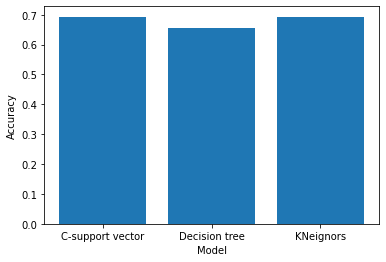

In [23]:
#Compare the results between the tree models
import matplotlib.pyplot as plt

df_plot = {"Models": ["C-support vector", "Decision tree", "KNeignors"], "Accuracy": [svmD.score(Xd_test,yd_test), treeD.score(Xd_test,yd_test), KNND.score(Xd_test,yd_test)]}
print (df_plot)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.bar(df_plot['Models'], df_plot['Accuracy'])
plt.show()
